In [195]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [196]:
# There are multiple genres per movie
df = pd.read_csv("dataset/movies_metadata.csv",usecols=['genres', 'overview'])
# Convert genres string type to list
df['genres'] = df['genres'].apply(lambda x: literal_eval(x)).apply(lambda x: sorted([d['name'] for d in x]))
df.head()

,genres,overview
0,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
1,"[Adventure, Family, Fantasy]",When siblings Judy and Peter discover an encha...
2,"[Comedy, Romance]",A family wedding reignites the ancient feud be...
3,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
4,[Comedy],Just when George Banks has recovered from his ...


In [197]:
print(f"There are {len(df)} rows in the dataset.")

There are 45466 rows in the dataset.


In [198]:
# Some movies have no overview, remove them
print(df['overview'].isnull().sum())
df = df.dropna(subset = ['overview']).reset_index(drop=True)

954


In [199]:
total_duplicate_titles = sum(df["overview"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 205 duplicate titles.


In [200]:
df = df[~df["overview"].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 44307 rows in the deduplicated dataset.


In [201]:
df['genres_str'] = df['genres'].apply(lambda x: " ".join(str(s) for s in x))

In [202]:
# There are some genres combinations with occurrence as low as 1.
print(sum(df["genres_str"].value_counts() == 1))

# How many unique terms?
print(df["genres_str"].nunique())

848
1910


In [203]:
# Remove movies with very short overviews
df_filtered = df[df["overview"].apply(lambda x: len(x.split(" "))) > 3]

In [204]:
# Filtering the rare genres combination
df_filtered = df_filtered.groupby("genres_str").filter(lambda x: len(x) > 1)[['overview', 'genres']]
df_filtered.shape

(43422, 2)

In [205]:
# Remove movies with no genres
df_filtered = df_filtered[df_filtered['genres'].apply(lambda x: len(x)) > 0]

In [206]:
genres = []
for x in df_filtered['genres']:
    if len(x) > 0:
        genres.extend(x)
pd.Series(genres).value_counts()

Drama              19549
Comedy             12427
Thriller            7295
Romance             6419
Action              6219
Horror              4484
Crime               4087
Documentary         3812
Adventure           3206
Science Fiction     2802
Family              2553
Mystery             2255
Fantasy             2055
Animation           1749
Music               1473
Foreign             1435
History             1273
War                 1228
Western              946
TV Movie             646
Name: count, dtype: int64

In [207]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["genres"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 33022
Number of rows in validation set: 4128
Number of rows in test set: 4128


In [208]:
genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Documentary', 'Adventure', 'Science Fiction', 'Family', 'Mystery', 'Fantasy', 'Animation', 'Music', 'Foreign', 'History', 'War', 'Western', 'TV Movie']


In [209]:
sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Drama', 'Romance']
Label-binarized representation: [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [210]:
train_df["overview"].apply(lambda x: len(x.split(" "))).describe()

count    33022.000000
mean        55.293289
std         34.614828
min          4.000000
25%         27.000000
50%         48.000000
75%         73.000000
max        187.000000
Name: overview, dtype: float64

In [316]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["overview"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [317]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [318]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Overview: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Overview: b'Based on a real-life case in 1925, two great lawyers argue the case for and against a science teacher accused of the crime of teaching evolution.'
Label(s): ['Drama']
 
Overview: b"In Philadelphia, a small-time bookie who stole mob money is in hiding and he begs a childhood friend to help him evade the hit-man who's on his trail."
Label(s): ['Drama' 'Action' 'Crime']
 
Overview: b'A group of honest police is sent to a country town to solve the problem of high crime. Soon they solve the problem while newcomer Francis (Cl\xc3\xa9o Pires) must overcome their limits to prove that it has value. They are acclaimed by public opinion. But before long the application of the force of the law begins to annoy everyone and the true enemy is revealed.'
Label(s): ['Thriller' 'Action']
 
Overview: b'Jenny Agutter plays Wynne, an adopted 14-year-old girl who has a crush on her 32-year-old stepbrother, George, played by Bryan Marshall. While spying on George in the bathroom, Wynne notices Ge

In [319]:
vocabulary = set()
train_df["overview"].str.lower().str.replace('[^\w\s]','').str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

130053


In [320]:
# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="tf_idf")

# text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=None, output_mode="count")

text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_seqlen, output_mode="int")

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [148]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

In [193]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Reshape((-1, 1)),
            layers.Conv1D(32, 3, activation='sigmoid'),
            layers.Conv1D(16, 3, activation='sigmoid'),
            layers.Flatten(),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

In [220]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Reshape((-1, 1)),
        ]
    )
    return shallow_mlp_model

epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    # metrics=[tf.keras.metrics.BinaryAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score(average='macro'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# shallow_mlp_model.build((None, 130076))
# shallow_mlp_model.summary()

In [321]:
text_batch, label_batch = next(iter(train_dataset))
text_batch.shape

TensorShape([128, 150])

In [322]:
a = text_batch.numpy()
# b = shallow_mlp_model.predict(text_batch)

In [323]:
(a[0] != 0).sum()

22

In [324]:
a[0]

array([27088,  4081,  3110,    26,  3127,     9,   174,  2125,     4,
         101,    72,     7,  1683,    62,    12,   664,    12,    69,
        1569,    21,    20,  1542,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [289]:
a.shape

(128, 79051)

In [280]:
b.shape

(128, 150, 1)

In [190]:
b[:, :, 0].shape

(32, 150)

In [191]:
(a == b[:, :, 0]).all()

True

In [194]:
epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", 
    optimizer="adam",
    # metrics=[tf.keras.metrics.BinaryAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Accuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.F1Score(average='macro'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping_monitor]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

Epoch 1/2


TypeError: in user code:

    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'conv1d_14' (type Conv1D).
    
    Value passed to parameter 'input' has DataType int64 not in list of allowed values: float16, bfloat16, float32, float64, int32
    
    Call arguments received by layer 'conv1d_14' (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 150, 1), dtype=int64)


In [327]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

33/33 [==============================] - 2s 68ms/step - loss: 0.2030 - binary_accuracy: 0.9219 - auc_2: 0.9059 - f1_score: 0.3074 - precision_2: 0.7058 - recall_2: 0.4221


ValueError: too many values to unpack (expected 2)

In [217]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

TypeError: Exception encountered when calling layer 'conv1d_14' (type Conv1D).

Value passed to parameter 'input' has DataType int64 not in list of allowed values: float16, bfloat16, float32, float64, int32

Call arguments received by layer 'conv1d_14' (type Conv1D):
  • inputs=tf.Tensor(shape=(None, 150, 1), dtype=int64)

In [218]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

predictions = []  # store predicted labels
labels = []  # store true labels

# iterate over the dataset
for text_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # append true labels
    labels.extend(label_batch)
    # compute predictions
    preds = shallow_mlp_model.predict(text_batch, verbose=0)
    # append predicted labels
    predictions.extend(preds)

predictions = np.array(predictions)
labels = np.array(labels)

TypeError: in user code:

    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'conv1d_14' (type Conv1D).
    
    Value passed to parameter 'input' has DataType int64 not in list of allowed values: float16, bfloat16, float32, float64, int32
    
    Call arguments received by layer 'conv1d_14' (type Conv1D):
      • inputs=tf.Tensor(shape=(32, 150, 1), dtype=int64)


In [339]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0

    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    f1 = f1_score(labels, pred, average='macro')
   
    # print("Micro-average quality numbers")
    print("Threshold: {:.4f}, Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, accuracy, precision, recall, f1))

Threshold: 0.1000, Accuracy: 0.0443, Precision: 0.2808, Recall: 0.7285, F1-measure: 0.3976
Threshold: 0.2000, Accuracy: 0.0945, Precision: 0.4024, Recall: 0.6010, F1-measure: 0.4688
Threshold: 0.3000, Accuracy: 0.1609, Precision: 0.5016, Recall: 0.4989, F1-measure: 0.4788
Threshold: 0.4000, Accuracy: 0.1991, Precision: 0.5704, Recall: 0.4073, F1-measure: 0.4519
Threshold: 0.5000, Accuracy: 0.2132, Precision: 0.6220, Recall: 0.3224, F1-measure: 0.4050
Threshold: 0.6000, Accuracy: 0.1863, Precision: 0.6315, Recall: 0.2410, F1-measure: 0.3344
Threshold: 0.7000, Accuracy: 0.1422, Precision: 0.6460, Recall: 0.1717, F1-measure: 0.2587
Threshold: 0.8000, Accuracy: 0.1005, Precision: 0.6781, Recall: 0.1156, F1-measure: 0.1868
Threshold: 0.9000, Accuracy: 0.0555, Precision: 0.6279, Recall: 0.0673, F1-measure: 0.1153


/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ghaithkazma/.pyenv/versions/3.11.3/envs/movies/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [305]:
# Binary accuracy doesn't give us much info since most labels are 0s
# For instance, if we predicted no genre for all movies, we would get
# a binary accuracy of ~0.897
(0 == labels).sum() / (4128*20)

0.8963299418604651

In [334]:
np.sum(np.all(np.equal(pred, labels), axis=1)) / (4128)

0.06322674418604651

In [243]:
pred.shape

(4128, 21)

In [274]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(labels, pred)
# print(cm)
# print( skm.classification_report(y_true,y_pred))

In [276]:
cm[0]

array([[4128,    0],
       [   0,    0]])

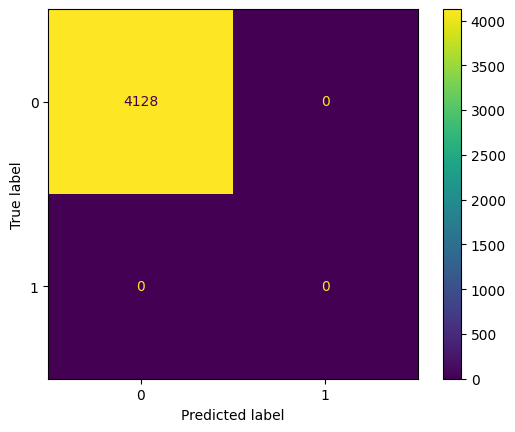

In [275]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=[0,1])
disp.plot()
plt.show()

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U33'), dtype('float32')) -> None

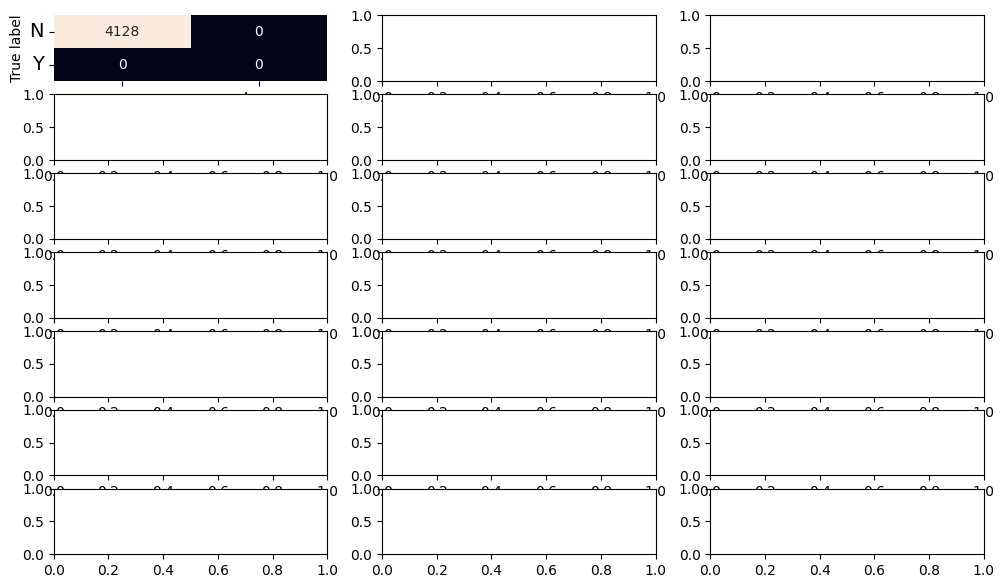

In [253]:
fig, ax = plt.subplots(7, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

In [273]:
cm.shape

(21, 2, 2)

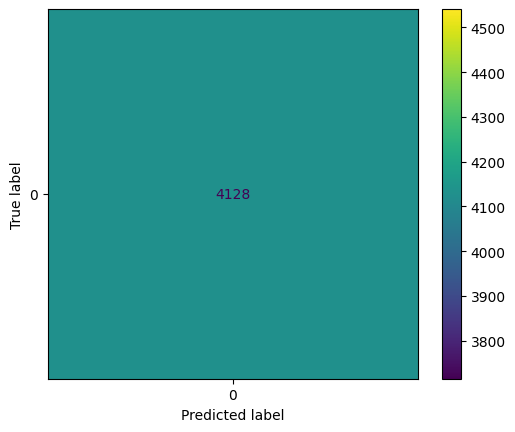

In [271]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(labels[:, i],
                                                   pred[:, i]))
disp.plot()

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

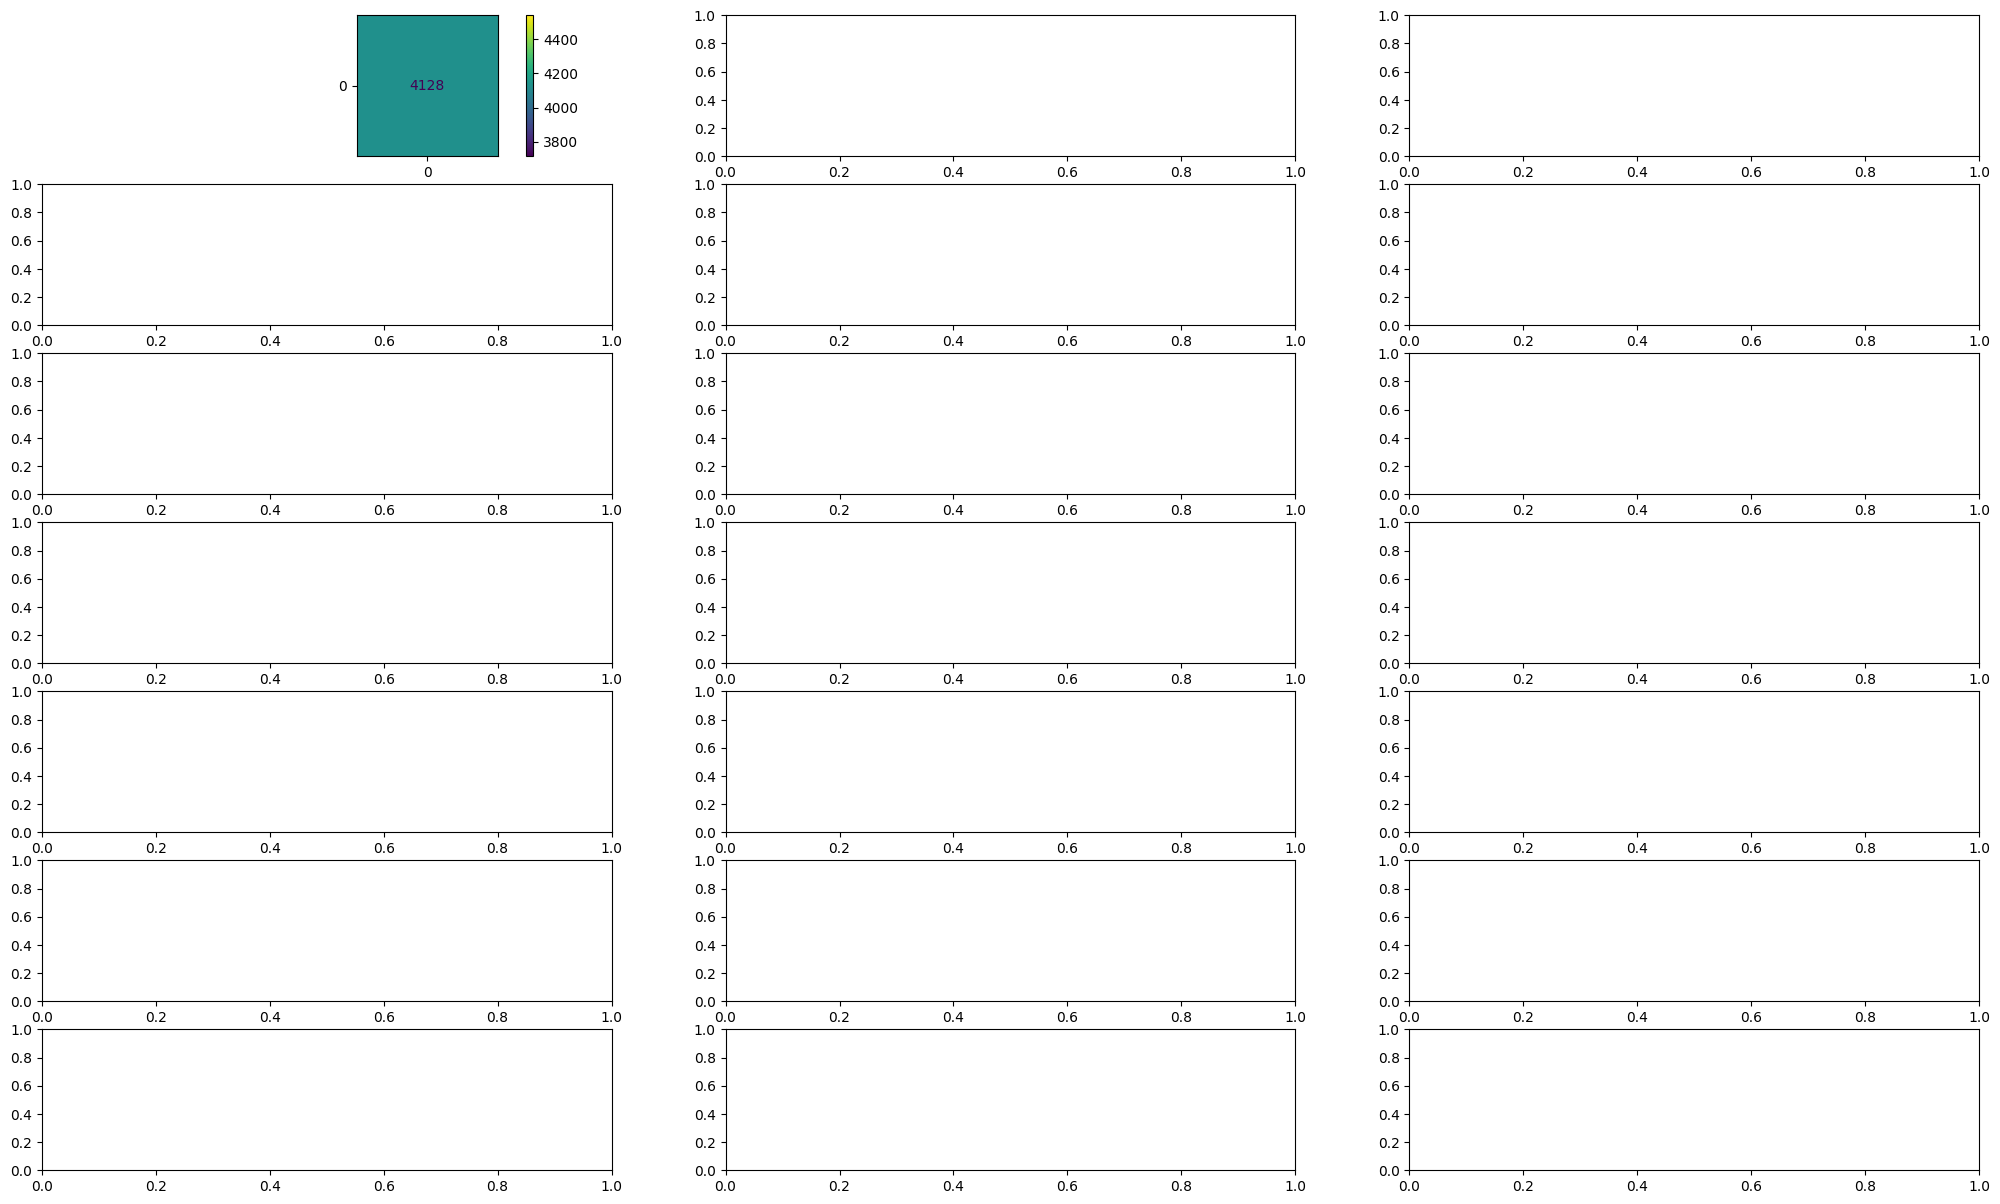

In [255]:
f, axes = plt.subplots(7, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(21):
    disp = ConfusionMatrixDisplay(confusion_matrix(labels[:, i],
                                                   pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<6:
        disp.ax_.set_xlabel('')
    if i%3!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()